# 4. Evaluation metrics

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

## 4.1 Session overview

In [4]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv'
df = pd.read_csv(data)

df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == 'yes').astype(int)

In [5]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [6]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = [
    'gender',
    'seniorcitizen',
    'partner',
    'dependents',
    'phoneservice',
    'multiplelines',
    'internetservice',
    'onlinesecurity',
    'onlinebackup',
    'deviceprotection',
    'techsupport',
    'streamingtv',
    'streamingmovies',
    'contract',
    'paperlessbilling',
    'paymentmethod',
]

In [7]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression()
model.fit(X_train, y_train)

/Users/vadim.sokoltsov/learning/datatalks.club/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [8]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

np.float64(0.8034066713981547)

## 4.2 Accurcay and dummy model

* Evaluate the model on different thresholds
* Check the accuracy of dummy baselines

In [9]:
len(y_val)

1409

In [10]:
(y_val == churn_decision).mean()

np.float64(0.8034066713981547)

In [11]:
1132/ 1409

0.8034066713981547

In [12]:
from sklearn.metrics import accuracy_score
accuracy_score(y_val, y_pred >= 0.5)

0.8034066713981547

In [13]:
thresholds = np.linspace(0, 1, 21)

scores = []

for t in thresholds:
    score = accuracy_score(y_val, y_pred >= t)
    print('%.2f %.3f' % (t, score))
    scores.append(score)

0.00 0.274
0.05 0.509
0.10 0.591
0.15 0.667
0.20 0.710
0.25 0.738
0.30 0.760
0.35 0.772
0.40 0.785
0.45 0.794
0.50 0.803
0.55 0.801
0.60 0.795
0.65 0.786
0.70 0.765
0.75 0.744
0.80 0.735
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


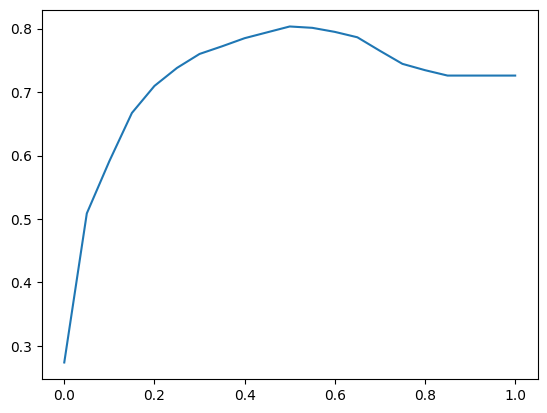

In [14]:
plt.plot(thresholds, scores)

In [15]:
from collections import Counter

In [16]:
Counter(y_pred >= 1)

Counter({np.False_: 1409})

In [17]:
1 - y_val.mean()

np.float64(0.7260468417317246)

## 4.3 Confusion table

* Different types of erros and correct decisions
* Arranging them in a table

In [18]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [19]:
t = 0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

In [20]:
predict_positive[:5]

array([False, False, False,  True, False])

In [21]:
actual_positive[:5]

array([False, False, False,  True, False])

In [22]:
predict_positive & actual_positive

array([False, False, False, ..., False,  True,  True], shape=(1409,))

In [23]:
tp = (predict_positive & actual_positive).sum()
tn = (predict_negative & actual_negative).sum()

fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()

In [24]:
fp, fn

(np.int64(101), np.int64(176))

In [25]:
confusion_matrix = np.array([
    [tn, fp],
    [fp, tp]
])
confusion_matrix

array([[922, 101],
       [101, 210]])

In [26]:
(confusion_matrix / confusion_matrix.sum()).round(2)

array([[0.69, 0.08],
       [0.08, 0.16]])

## 4.4 Precision and Recall

### Precision

* Fraction of positive predictions

In [27]:
precision = tp / (tp + fp)
precision

np.float64(0.6752411575562701)

### Recall

Fraction of correctly identified positive examples

In [28]:
recall = tp / (tp + fn)
recall

np.float64(0.5440414507772021)

## 4.5 ROC curves

### ROC

Receiving Operating Characteristics

### TRP and FPR

* TRP - true positive rate
* FPR - false positive rate

In [29]:
tpr = tp / (tp + fn)
tpr

np.float64(0.5440414507772021)

In [30]:
recall

np.float64(0.5440414507772021)

In [31]:
fpr = fp / (fp + tn)
fpr

np.float64(0.09872922776148582)

In [32]:
scores = []
thresholds = np.linspace(0, 1, 101)
for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    scores.append((t, tp, fp, fn, tn))

In [33]:
scores

[(np.float64(0.0), np.int64(386), np.int64(1023), np.int64(0), np.int64(0)),
 (np.float64(0.01), np.int64(385), np.int64(913), np.int64(1), np.int64(110)),
 (np.float64(0.02), np.int64(384), np.int64(830), np.int64(2), np.int64(193)),
 (np.float64(0.03), np.int64(383), np.int64(766), np.int64(3), np.int64(257)),
 (np.float64(0.04), np.int64(381), np.int64(715), np.int64(5), np.int64(308)),
 (np.float64(0.05), np.int64(379), np.int64(685), np.int64(7), np.int64(338)),
 (np.float64(0.06), np.int64(377), np.int64(661), np.int64(9), np.int64(362)),
 (np.float64(0.07), np.int64(372), np.int64(641), np.int64(14), np.int64(382)),
 (np.float64(0.08), np.int64(371), np.int64(613), np.int64(15), np.int64(410)),
 (np.float64(0.09), np.int64(369), np.int64(580), np.int64(17), np.int64(443)),
 (np.float64(0.1), np.int64(366), np.int64(556), np.int64(20), np.int64(467)),
 (np.float64(0.11), np.int64(365), np.int64(528), np.int64(21), np.int64(495)),
 (np.float64(0.12), np.int64(365), np.int64(510), 

In [34]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores[::10]

,threshold,tp,fp,fn,tn
0,0.0,386,1023,0,0
10,0.1,366,556,20,467
20,0.2,333,356,53,667
30,0.3,284,236,102,787
40,0.4,249,166,137,857
50,0.5,210,101,176,922
60,0.6,150,53,236,970
70,0.7,75,20,311,1003
80,0.8,13,1,373,1022
90,0.9,0,0,386,1023


In [35]:
df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

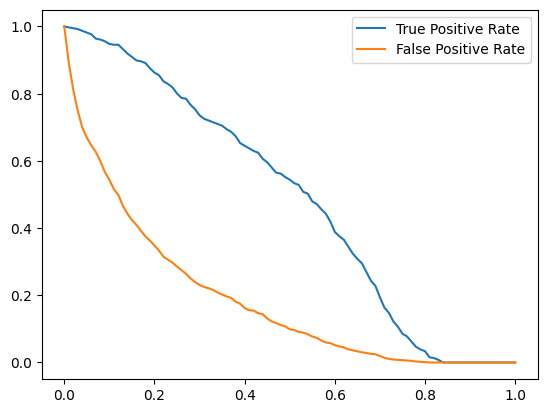

In [36]:
plt.plot(df_scores.threshold, df_scores['tpr'], label='True Positive Rate')
plt.plot(df_scores.threshold, df_scores['fpr'], label='False Positive Rate')
plt.legend()

### Random model

In [37]:
np.random.seed(1)
y_rand = np.random.uniform(0, 1, size=len(y_val))
y_rand

array([4.17022005e-01, 7.20324493e-01, 1.14374817e-04, ...,
       7.73916250e-01, 3.34276405e-01, 8.89982208e-02], shape=(1409,))

In [38]:
((y_rand >= 0.5) == y_val).mean()

np.float64(0.5017743080198722)

In [39]:
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
    
    return df_scores

In [40]:
df_rand = tpr_fpr_dataframe(y_val, y_rand)

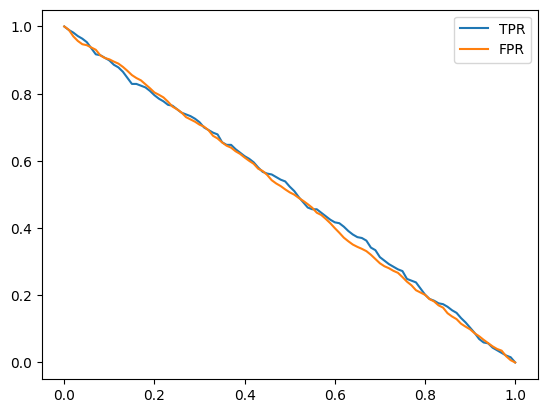

In [41]:
plt.plot(df_rand.threshold, df_rand['tpr'], label='TPR')
plt.plot(df_rand.threshold, df_rand['fpr'], label='FPR')
plt.legend()

### Ideal model

In [42]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()
num_neg, num_pos

(np.int64(1023), np.int64(386))

In [43]:
y_ideal = np.repeat([0, 1], [num_neg, num_pos])
y_ideal

y_ideal_pred = np.linspace(0, 1, len(y_val))

In [44]:
1 - y_val.mean()

np.float64(0.7260468417317246)

In [45]:
accuracy_score(y_ideal, y_ideal_pred >= 0.726)

1.0

In [46]:
df_ideal = tpr_fpr_dataframe(y_ideal, y_ideal_pred)
df_ideal[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,386,882,0,141,1.000000,0.862170
20,0.2,386,741,0,282,1.000000,0.724340
30,0.3,386,600,0,423,1.000000,0.586510
40,0.4,386,459,0,564,1.000000,0.448680
50,0.5,386,319,0,704,1.000000,0.311828
60,0.6,386,178,0,845,1.000000,0.173998
70,0.7,386,37,0,986,1.000000,0.036168
80,0.8,282,0,104,1023,0.730570,0.000000
90,0.9,141,0,245,1023,0.365285,0.000000


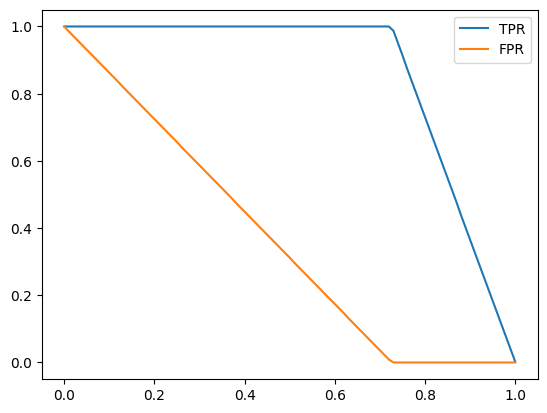

In [47]:
plt.plot(df_ideal.threshold, df_ideal['tpr'], label='TPR')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label='FPR')
plt.legend()

## Putting everything together

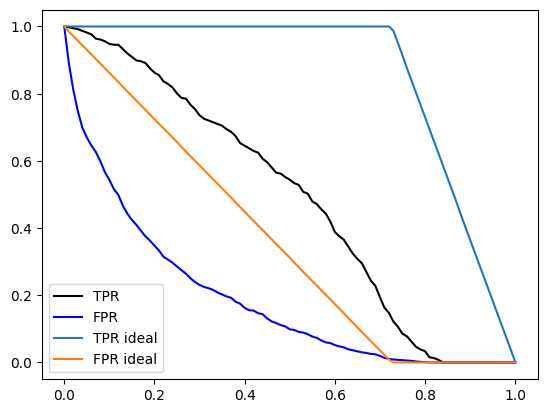

In [48]:
plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR', color='black')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR', color='blue')

plt.plot(df_ideal.threshold, df_ideal['tpr'], label='TPR ideal')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label='FPR ideal')

plt.legend()

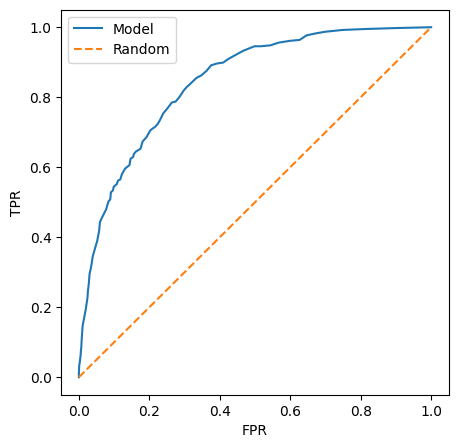

In [49]:
plt.figure(figsize=(5, 5))

plt.plot(df_scores.fpr, df_scores.tpr, label='Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

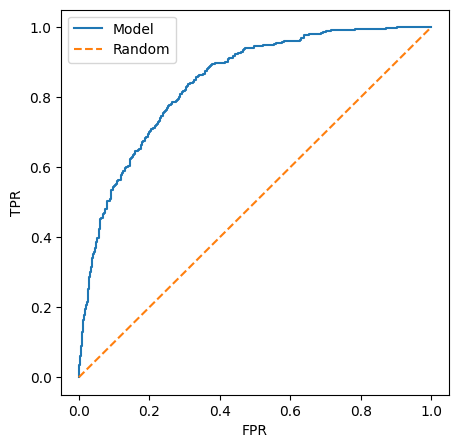

In [50]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
plt.figure(figsize=(5, 5))

plt.plot(fpr, tpr, label='Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

## 4.6 ROC AUC

* Area under the curve
* Interpretation of AUC

In [51]:
from sklearn.metrics import auc

In [52]:
auc(fpr, tpr)

0.8437795977491782

In [53]:
auc(df_scores.fpr, df_scores.tpr)

0.8438365773732647

In [54]:
auc(df_ideal.fpr, df_ideal.tpr)

0.9999430203759136

In [55]:
from sklearn.metrics import roc_auc_score

In [56]:
roc_auc_score(y_val, y_pred)

0.8437795977491782

In [57]:
neg = y_pred[y_val == 0]
pos = y_pred[y_val == 1]

In [58]:
import random

In [59]:
n = 10000
success = 0
for i in range(n):
    pos_ind = random.randint(0, len(pos) - 1)
    neg_ind = random.randint(0, len(pos) - 1)
    if pos[pos_ind] > neg[neg_ind]:
        success += 1

success / n

0.8456

In [60]:
n = 10000
pos_ind = np.random.randint(0, len(pos), size=n)
neg_ind = np.random.randint(0, len(pos), size=n)

(pos[pos_ind] > neg[neg_ind]).mean()

np.float64(0.8464)

## 4.7 Cross-validation

* Evaliauting the same model on different subsets of data
* Getting the average prediction and the spread withing predictions

In [87]:
def train(df, y, C=1.0):
    dicts = df[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(C=C, max_iter=10000)
    model.fit(X_train, y)

    return dv, model

In [92]:
dv, model = train(df_train, y_train, C=0.001)

In [89]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [67]:
y_pred = predict(df_val, dv, model)

In [68]:
from sklearn.model_selection import KFold

In [69]:
kfold = KFold(n_splits=10, shuffle=True, random_state=1)

In [ ]:
from tqdm.auto import tqdm

In [94]:
n_splits =5 
for C in tqdm([0.001, 0.01, 0.1, 0.5, 1, 5, 10], total=n_splits):
    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.churn.values
        y_val = df_val.churn.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc_ = roc_auc_score(y_val, y_pred)
        scores.append(auc_)
    
    print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

  0%|          | 0/5 [00:00<?, ?it/s]

0.842 +- 0.012
0.842 +- 0.012
0.842 +- 0.012
0.842 +- 0.012
0.842 +- 0.012
0.842 +- 0.012


KeyboardInterrupt: 

In [95]:
df_full_train

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,...,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
1814,5442-pptjy,male,0,yes,yes,12,yes,no,no,no_internet_service,...,no_internet_service,no_internet_service,no_internet_service,no_internet_service,two_year,no,mailed_check,19.70,258.35,0
5946,6261-rcvns,female,0,no,no,42,yes,no,dsl,yes,...,yes,yes,no,yes,one_year,no,credit_card_(automatic),73.90,3160.55,1
3881,2176-osjuv,male,0,yes,no,71,yes,yes,dsl,yes,...,no,yes,no,no,two_year,no,bank_transfer_(automatic),65.15,4681.75,0
2389,6161-erdgd,male,0,yes,yes,71,yes,yes,dsl,yes,...,yes,yes,yes,yes,one_year,no,electronic_check,85.45,6300.85,0
3676,2364-ufrom,male,0,no,no,30,yes,no,dsl,yes,...,no,yes,yes,no,one_year,no,electronic_check,70.40,2044.75,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
905,0781-lkxbr,male,1,no,no,9,yes,yes,fiber_optic,no,...,yes,no,yes,yes,month-to-month,yes,electronic_check,100.50,918.60,1
5192,3507-gasnp,male,0,no,yes,60,yes,no,no,no_internet_service,...,no_internet_service,no_internet_service,no_internet_service,no_internet_service,two_year,no,mailed_check,19.95,1189.90,0
3980,8868-wozgu,male,0,no,no,28,yes,yes,fiber_optic,no,...,yes,no,yes,yes,month-to-month,yes,electronic_check,105.70,2979.50,1
235,1251-krreg,male,0,no,no,2,yes,yes,dsl,no,...,no,no,no,no,month-to-month,yes,mailed_check,54.40,114.10,1


In [ ]:
dv, model = train(df_full_train, df_full_train.churn.values, C=1.0)
y_pred = predict(df_test, dv, model)

auc_ = roc_auc_score(y_test, y_pred)
auc_

0.858373416967294

In [72]:
len(train_idx), len(val_idx)

(5070, 564)

In [73]:
df_train = df_full_train.iloc[train_idx]
df_val = df_full_train.iloc[val_idx]

## 4.8 Summary

* Metric - a single number that describes the performance of a model
* Accuracy - fraction of correct answers; sometimes misleading 
* Precision and recall are less misleading when we have class inbalance
* ROC Curve - a way to evaluate the performance at all thresholds; okay to use with imbalance
* K-Fold CV - more reliable estimate for performance (mean + std)

## 4.9 Explore more

* Check the precision and recall of the dummy classifier that always predict "FALSE"
* F1 score = 2 * P * R / (P + R)
* Evaluate precision and recall at different thresholds, plot P vs R - this way you'll get the precision/recall curve (similar to ROC curve)
* Area under the PR curve is also a useful metric

Other projects:

* Calculate the metrics for datasets from the previous week